# **ВТОРАЯ ЧАСТЬ  - МОДЕЛИРОВАНИЕ'**

---

*   2) Data modelling Предсказание совершение целевого действия(ориентировочное значение ROC-AUC ~ 0.65) — факт совершения пользователей целевого действия.Разработать модель предсказания совершения одного из целевых действий ("Заказать звонок", "Оставить заявку") для сессий по введенным атрибутам типа utm_, device_, geo_* и упаковать модель в сервис.


*   3) Deployment Упаковка получившейся модели в сервис, который будет брать на вход все атрибуты, типа utm_*, device_*, geo_*, и отдавать на выход 0/1 (1 — если пользователь совершит любое целевое действие)

*   4) Подговка получившихся артефактов, проверка их на соответствие итоговым критериям оценки 




Целевая метрика: ориентировочное значение roc-auc > 0.65 — факт совершения пользователем целевого действия.

Формат вывода ответа - 0/1

Скорость ответа сервиса - не более 3 секунд

Сервис - это должен быть (минимум) - py-скрипт с инструкцией по запуску, (максимум) - localhost web app.




# **ИМПОРТ БИБЛИОТЕК**

---

In [1]:
!pip install xgboost 
!pip install lightgbm 
!pip install bayesian-optimization
!pip install feature-engine
!pip install bayesian-optimization
!pip install colorama



import scipy
import sys
from datetime import datetime
import warnings
from pathlib import Path
from typing import Union
from functools import partial
import time
import os
import warnings
warnings.filterwarnings('ignore')

# препроцессинг и метрики

from matplotlib import pyplot
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.model_selection import (
    train_test_split, GridSearchCV, StratifiedKFold)
from sklearn.metrics import (
    roc_auc_score, accuracy_score, confusion_matrix, precision_score, 
    recall_score, f1_score, make_scorer, roc_curve)
from sklearn.pipeline import Pipeline
from feature_engine.encoding import RareLabelEncoder, OneHotEncoder
from feature_engine.wrappers import SklearnTransformerWrapper
from feature_engine.outliers import Winsorizer
from feature_engine.selection import (
    DropDuplicateFeatures, DropConstantFeatures, 
    DropCorrelatedFeatures, DropFeatures)
from feature_engine.transformation import YeoJohnsonTransformer
from bayes_opt import BayesianOptimization

# модели
from sklearn.base import BaseEstimator
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, HistGradientBoostingClassifier)
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Загрузка датасет sessions.csv с колонкой target

In [35]:
path = os.path.expanduser('~/PycharmProjects/FinalFantasyProj/')
start = time.time() # включим таймер для подсчета времени чтения файла в датасет
df_session = pd.read_csv(path + 'df_sessions_prepared_for_modelling.csv', low_memory=False)
elapsed_time = time.time() - start # зафиксируем время чтения файлма в датасет
print(f'Датасет сеансов успешно прочитан из файла ga_sessions.csv, \nРазмеры датасета: {df_session.shape}, \nВремя чтения файла в датасет: {elapsed_time:.3f}')

Датасет сеансов успешно прочитан из файла ga_sessions.csv, 
Размеры датасета: (1128602, 28), 
Время чтения файла в датасет: 2.928


# ПОДГОТОВКА К МОДЕЛИРОВАНИЮ

---
Существуют различные способы повышения качества работы моделей машинного обучения. Одним из таких способов является создание новых признаков. в блокноте 1 части создались такие новые признаки как 
car_brand
car_model
visit_date_day
visit_time_hour
visit_time_night
visit_number_no_outliers
device_screen_width
device_screen_height
device_screen_area
device_screen_ratio




In [70]:
df_session.describe(include='all')
#удалим категориальные колонки, которые не будем преобразовывать в OHE
df_session = df_session.drop(['visit_number', 'utm_source', 'utm_medium', 'utm_campaign',
                             'utm_adcontent', 'device_brand', 'device_screen_resolution', 
                             'geo_country', 'geo_city', 'visit_date_weekend'], axis=1)
print(df_session.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128602 entries, 0 to 1128601
Data columns (total 18 columns):
 #   Column                                  Non-Null Count    Dtype  
---  ------                                  --------------    -----  
 0   device_category                         1128602 non-null  object 
 1   device_browser                          1128602 non-null  object 
 2   target                                  1128602 non-null  int64  
 3   car_brand                               1128602 non-null  object 
 4   car_model                               1128602 non-null  object 
 5   visit_date_weekday                      1128602 non-null  int64  
 6   visit_date_month                        1128602 non-null  int64  
 7   visit_date_day                          1128602 non-null  int64  
 8   visit_time_hour                         1128602 non-null  int64  
 9   visit_time_night                        1128602 non-null  bool   
 10  device_screen_width           

In [143]:
target = df_session['target']
target

0          0
1          0
2          0
3          0
4          0
          ..
1128597    0
1128598    0
1128599    0
1128600    0
1128601    0
Name: target, Length: 959336, dtype: int64

In [67]:
df_session['device_browser'].value_counts()
df_session.loc[df_session['device_browser'] == '(not set)', 'device_browser'] = df_session['device_browser'].apply(lambda x: 'Chrome')
df_session.loc[df_session['device_browser'] == 'Instagram 208.0.0.32.135 Android', 'device_browser'] = df_session['device_browser'].apply(lambda x: 'Instagram')
df_session.loc[df_session['device_browser'] == 'Instagram 209.0.0.21.119 Android', 'device_browser'] = df_session['device_browser'].apply(lambda x: 'Instagram')
df_session.loc[df_session['device_browser'] == 'Instagram 207.0.0.28.118', 'device_browser'] = df_session['device_browser'].apply(lambda x: 'Instagram')
df_session.loc[df_session['device_browser'] == 'Instagram 216.0.0.12.135', 'device_browser'] = df_session['device_browser'].apply(lambda x: 'Instagram')
df_session.loc[df_session['device_browser'] == 'Instagram 216.1.0.21.137 Android', 'device_browser'] = df_session['device_browser'].apply(lambda x: 'Instagram')
df_session.loc[df_session['device_browser'] == 'Instagram 208.0.0.26.131', 'device_browser'] = df_session['device_browser'].apply(lambda x: 'Instagram')
df_session.loc[df_session['device_browser'] == 'Mozilla Compatible Agent', 'device_browser'] = df_session['device_browser'].apply(lambda x: 'Mozilla')
df_session.loc[df_session['device_browser'] == 'Coc Coc', 'device_browser'] = df_session['device_browser'].apply(lambda x: 'other')
df_session.loc[df_session['device_browser'] == 'Konqueror', 'device_browser'] = df_session['device_browser'].apply(lambda x: 'other')
df_session.loc[df_session['device_browser'] == 'Nokia501', 'device_browser'] = df_session['device_browser'].apply(lambda x: 'other')
df_session.loc[df_session['device_browser'] == 'NokiaX2-02', 'device_browser'] = df_session['device_browser'].apply(lambda x: 'other')
df_session.loc[df_session['device_browser'] == 'MyApp', 'device_browser'] = df_session['device_browser'].apply(lambda x: 'other')
df_session.loc[df_session['device_browser'] == 'SeaMonkey', 'device_browser'] = df_session['device_browser'].apply(lambda x: 'other')
df_session.loc[df_session['device_browser'] == 'Android Browser', 'device_browser'] = df_session['device_browser'].apply(lambda x: 'Android Webview')
df_session.loc[df_session['device_browser'] == 'Opera Mini', 'device_browser'] = df_session['device_browser'].apply(lambda x: 'Opera')
df_session.loc[df_session['device_browser'] == '[FBAN', 'device_browser'] = df_session['device_browser'].apply(lambda x: 'FBAN')


In [44]:
df_session['utm_medium'].value_counts()
df_session.loc[df_session['utm_medium'] == '(not set)', 'utm_medium'] = df_session['utm_medium'].apply(lambda x: 'banner')

In [71]:
df_session

,device_category,device_browser,target,car_brand,car_model,visit_date_weekday,visit_date_month,visit_date_day,visit_time_hour,visit_time_night,device_screen_width,device_screen_height,device_screen_area,device_screen_ratio,geo_country_is_russia,geo_city_is_big,geo_city_distance_from_moscow,geo_city_distance_from_moscow_category
0,mobile,Chrome,0,skoda,rapid,1,12,28,2,True,360,720,259200,0.500000,True,True,3336.039750,>= 3000 km
1,mobile,Chrome,0,skoda,rapid,5,5,29,5,True,393,786,308898,0.500000,True,True,0.000000,moscow
2,mobile,Safari,0,skoda,rapid,0,5,31,12,False,375,812,304500,0.461823,True,True,636.169514,500-1000 km
3,tablet,YaBrowser,0,skoda,rapid,3,12,30,8,True,602,1029,619458,0.585034,True,True,636.169514,500-1000 km
4,mobile,Chrome,0,skoda,rapid,0,7,12,19,False,360,640,230400,0.562500,True,True,636.169514,500-1000 km
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128597,mobile,Chrome,0,skoda,rapid,5,12,4,9,False,384,854,327936,0.449649,True,False,1127.659720,1000-3000 km
1128598,mobile,Chrome,0,nissan,x-trail,5,12,4,9,False,384,854,327936,0.449649,True,False,1127.659720,1000-3000 km
1128599,mobile,Safari,0,skoda,rapid,2,5,26,8,True,390,844,329160,0.462085,True,False,1278.987697,1000-3000 km
1128600,mobile,Safari,0,mercedes-benz,glc,0,11,15,15,False,375,667,250125,0.562219,True,True,0.000000,moscow


# Нормализация данных

In [74]:
# еще одна нормализация - это min-max нормализация значения [0;1]
from sklearn.preprocessing import MinMaxScaler
minmax_data=df_session[['device_screen_width', 'device_screen_height', 'device_screen_area', 
                        'device_screen_ratio', 'geo_city_distance_from_moscow', 'device_screen_width',
                       'device_screen_height', 'device_screen_area', 'device_screen_ratio']]
mm_scaler = MinMaxScaler()
mm_scaler
mm_scaler.fit(minmax_data)
mm_scaled = mm_scaler.transform(minmax_data)

In [75]:
df_session[['device_screen_width', 'device_screen_height', 'device_screen_area', 
                        'device_screen_ratio', 'geo_city_distance_from_moscow','device_screen_width',
                       'device_screen_height', 'device_screen_area', 'device_screen_ratio']] = mm_scaled

In [76]:
df_session

,device_category,device_browser,target,car_brand,car_model,visit_date_weekday,visit_date_month,visit_date_day,visit_time_hour,visit_time_night,device_screen_width,device_screen_height,device_screen_area,device_screen_ratio,geo_country_is_russia,geo_city_is_big,geo_city_distance_from_moscow,geo_city_distance_from_moscow_category
0,mobile,Chrome,0,skoda,rapid,1,12,28,2,True,0.032258,0.095395,0.009640,0.034063,True,True,0.490812,>= 3000 km
1,mobile,Chrome,0,skoda,rapid,5,5,29,5,True,0.038172,0.108964,0.012016,0.034063,True,True,0.000147,moscow
2,mobile,Safari,0,skoda,rapid,0,5,31,12,False,0.034946,0.114309,0.011806,0.026433,True,True,0.093715,500-1000 km
3,tablet,YaBrowser,0,skoda,rapid,3,12,30,8,True,0.075627,0.158923,0.026865,0.051057,True,True,0.093715,500-1000 km
4,mobile,Chrome,0,skoda,rapid,0,7,12,19,False,0.032258,0.078947,0.008262,0.046553,True,True,0.093715,500-1000 km
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128597,mobile,Chrome,0,skoda,rapid,5,12,4,9,False,0.036559,0.122944,0.012926,0.024000,True,False,0.166003,1000-3000 km
1128598,mobile,Chrome,0,nissan,x-trail,5,12,4,9,False,0.036559,0.122944,0.012926,0.024000,True,False,0.166003,1000-3000 km
1128599,mobile,Safari,0,skoda,rapid,2,5,26,8,True,0.037634,0.120888,0.012985,0.026486,True,False,0.188261,1000-3000 km
1128600,mobile,Safari,0,mercedes-benz,glc,0,11,15,15,False,0.034946,0.084498,0.009206,0.046497,True,True,0.000147,moscow


## Square, sqrt & log of numerical columns

In [77]:
def sqr_sqrt_log_features_transform(df_session: pd.DataFrame,
                                    sqr_miss: list=None,
                                    sqrt_miss: list=None,
                                    log_miss: list=None,
                                   ) -> pd.DataFrame:
    """
    Function transforms dataset adding squares, square roots and logarithm of numerical features
    
    :param df:  input data frame
    :sqr_miss:  columns, that should be missed for square feature generation
    :sqrt_miss: columns, that should be missed for square root feature generation
    :log_miss:  columns, that should be missed for logarithm feature generation
    
    :return:    dataframe with added features
    """
    
    df = df_session.copy()
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if ~np.isin(col, sqrt_miss):
            df[f'{col}_sqr'] = np.square(df[col])
        if ~np.isin(col, sqrt_miss):
            df[f'{col}_sqrt'] = np.sqrt(df[col])
        if ~np.isin(col, log_miss):
            df[f'{col}_log'] = np.log(df[col] + 0.01)    
    return df

In [78]:
df_session = sqr_sqrt_log_features_transform(df_session, 
                                       sqr_miss=['target'],
                                       sqrt_miss=['target'],
                                       log_miss=['target'],
                                     )
df_session.shape

(1128602, 45)

In [79]:
df_session.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128602 entries, 0 to 1128601
Data columns (total 45 columns):
 #   Column                                  Non-Null Count    Dtype  
---  ------                                  --------------    -----  
 0   device_category                         1128602 non-null  object 
 1   device_browser                          1128602 non-null  object 
 2   target                                  1128602 non-null  int64  
 3   car_brand                               1128602 non-null  object 
 4   car_model                               1128602 non-null  object 
 5   visit_date_weekday                      1128602 non-null  int64  
 6   visit_date_month                        1128602 non-null  int64  
 7   visit_date_day                          1128602 non-null  int64  
 8   visit_time_hour                         1128602 non-null  int64  
 9   visit_time_night                        1128602 non-null  bool   
 10  device_screen_width           

# FEATURE GENERATION

In [80]:
for_ohe=df_session[['device_category', 'car_brand', 'car_model', 'visit_time_night', 
                    'geo_country_is_russia', 'geo_city_is_big', 
                    'geo_city_distance_from_moscow_category', 'device_browser']]

In [81]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
ohe.fit(for_ohe)
ohe.get_feature_names()
ohe_categor = ohe.transform(for_ohe)
df_session[ohe.get_feature_names()] = ohe_categor
df_session.shape

(1128602, 166)

In [82]:
#удалим категориальные колонки
df_session = df_session.drop(['device_category', 'car_brand', 'car_model', 'visit_time_night', 
                    'geo_country_is_russia', 'geo_city_is_big', 
                    'geo_city_distance_from_moscow_category', 'device_browser'], axis=1)
df_session.shape

(1128602, 158)

In [83]:
# проверим на дубликаты, удалим их
df_session[df_session.duplicated()]
df_session = df_session.drop_duplicates()
df_session[df_session.duplicated()]

,target,visit_date_weekday,visit_date_month,visit_date_day,visit_time_hour,device_screen_width,device_screen_height,device_screen_area,device_screen_ratio,geo_city_distance_from_moscow,...,x7_Mozilla,x7_Opera,x7_Puffin,x7_Safari,x7_Safari (in-app),x7_Samsung Internet,x7_UC Browser,x7_YaBrowser,x7_helloworld,x7_other


In [84]:
df_session=df_session.dropna(how='all') 

In [85]:
df_session.shape

(959336, 158)

# Поиск лучшего порога перевода вероятностей к совершению целевого действия пользователем

In [86]:
def find_best_threshold(
    y_true: pd.Series, 
    y_proba: pd.Series, 
    metriс_name: str = 'roc_auc', 
    iterations: int = 250, 
    learning_rate: float = 0.05
) -> float:
    """Находит лучший порог перевода вероятностей `y_proba` 
    в принадлежность к классу 1.
    """
    
    # Получение функции метрики, которую оптимизируем
    metrics = {'roc_auc': roc_auc_score, 'f1': f1_score, 
               'precision': precision_score, 'recall': recall_score}
    metric_function = metrics.get(metriс_name, accuracy_score)

    # Получение метрики
    def get_metric(threshold: float) -> float:
        prediction = (y_proba > threshold).astype(int)
        return metric_function(y_true, prediction)

    direction = -1
    shift = 0.25

    best_threshold = 0.5
    best_metric = get_metric(best_threshold)

    # На каждой итерации
    for i in range(iterations):

        # Меняем порог
        threshold = best_threshold + direction * shift
        shift *= (1 - learning_rate)
        metric = get_metric(threshold)

        # И проверяем, улучшилась ли метрика
        if metric > best_metric: 
            best_threshold = threshold
            best_metric = metric
        else: 
            direction *= -1
            
    return best_threshold

In [87]:
def print_metrics(
    model: BaseEstimator, 
    X: pd.DataFrame, 
    y: pd.Series, 
    threshold: Union[float, None] = None, 
    show_roc_curve: bool = False
) -> None:
    """Получает метрики бинарной классификации из модели `model` на данных 
    `X` и `y`. Если возможно, то через метод `predict_proba` с заданным 
    порогом перевода вероятностей в классы `threshold`, иначе через `predict`. 
    Если `threshold` равен None, автоматически найдёт лучший порог.  
    ---
    Метрики: roc_auc, accuracy, precision, recall, f1, confusion_matrix, 
    roc_curve.
    """

    # Получим предсказания, если возможно в виде вероятностей
    try: 
        probas = model.predict_proba(X)[:, 1]
    except AttributeError:
        prediction = model.predict(X)
        threshold = None
        probas = None
    else:
        threshold = threshold or find_best_threshold(y, probas, 'roc_auc')
        prediction = (probas > threshold).astype(int)

    # Распечатаем порог перевода вероятностей в классы
    if threshold is None:
        print("Порог перевода вероятностей в классы: не используется")
    else:
        print(f"Порог перевода вероятностей в классы: {threshold}")
        print(f"{roc_auc_score(y, probas)} - roc_auc на вероятностях")

    # Распечатаем однострочные метрики
    print()
    print(f"{roc_auc_score(y, prediction):0.8f} - roc_auc")
    print(f"{accuracy_score(y, prediction):0.8f} - accuracy")
    print(f"{precision_score(y, prediction):0.8f} - precision")
    print(f"{recall_score(y, prediction):0.8f} - recall")
    print(f"{f1_score(y, prediction):0.8f} - f1")

    # Распечатаем матрицу ошибок
    conf_mat = confusion_matrix(y, prediction)
    classes = model.classes_
    n_classes = len(classes)
    print()
    print("|".join(f"{i:^10}" for i in ["prediction"] + list(classes)))
    print(f"{'true label':^10}" + ("|" + " " * 10) * n_classes)
    print("-" * ((n_classes * 10) + n_classes + 10))
    for i in range(n_classes):
        print("|".join(f"{j:>10}" for j in [classes[i]] + list(conf_mat[i])))

    # Отобразим ROC-кривую
    if show_roc_curve:
        print()
        plt.figure(figsize=(7, 4))
        if probas is not None:
            plt.plot(*roc_curve(y_test, probas)[:2], 
                     c='r', label='on probability')
        plt.plot(*roc_curve(y_test, prediction)[:2], c='b', label='on class')
        plt.plot([0, 1], [0, 1], c='y', label='random', linestyle='dashed')
        plt.title('Receiver operating characteristic')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()

# train-test split
Оценим базовую модель.
Так как целевая переменная распределена не равномерно, то в качестве бейзлайна можно выбрать стратегию, которая для каждой сессии предсказывает значение 0.

In [88]:
train_no_revenue_tree=df_session.drop(['target'], axis=1)
train_no_revenue_tree.shape
X=train_no_revenue_tree
y=df_session['target']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)

# Baseline model

In [89]:
# Обучим базовую модель 
baseline = DummyClassifier(strategy='constant', constant=0)
baseline.fit(x_train, y_train)

# И получим её метрики
print_metrics(baseline, y_test, y_test, 0.5)

Порог перевода вероятностей в классы: 0.5
0.5 - roc_auc на вероятностях

0.50000000 - roc_auc
0.94732124 - accuracy
0.00000000 - precision
0.00000000 - recall
0.00000000 - f1

prediction|    0     |    1     
true label|          |          
--------------------------------
         0|    272640|         0
         1|     15161|         0


# LogisticRegression model

In [90]:
logreg = LogisticRegression(random_state=128)
logreg.fit(x_train, y_train)
print_metrics(logreg, x_test, y_test)

Порог перевода вероятностей в классы: 0.5
0.6118050102946294 - roc_auc на вероятностях

0.50000000 - roc_auc
0.94732124 - accuracy
0.00000000 - precision
0.00000000 - recall
0.00000000 - f1

prediction|    0     |    1     
true label|          |          
--------------------------------
         0|    272640|         0
         1|     15161|         0


# LinearSVC model опорных векторов

In [91]:
svc = LinearSVC(class_weight='balanced')
svc.fit(x_train, y_train)
print_metrics(svc, x_test, y_test)

Порог перевода вероятностей в классы: не используется

0.50000000 - roc_auc
0.94732124 - accuracy
0.00000000 - precision
0.00000000 - recall
0.00000000 - f1

prediction|    0     |    1     
true label|          |          
--------------------------------
         0|    272640|         0
         1|     15161|         0


# MLPClassifier model нейронки

In [92]:
mlp = MLPClassifier((32,), random_state=128)
mlp.fit(x_train, y_train);
print_metrics(mlp, x_test, y_test)

Порог перевода вероятностей в классы: 0.5
0.6369867574584049 - roc_auc на вероятностях

0.50000000 - roc_auc
0.94732124 - accuracy
0.00000000 - precision
0.00000000 - recall
0.00000000 - f1

prediction|    0     |    1     
true label|          |          
--------------------------------
         0|    272640|         0
         1|     15161|         0


# GaussianNB model Байесовский классификатор

In [93]:
gaussnb = GaussianNB()
gaussnb.fit(x_train, y_train)
print_metrics(gaussnb, x_test, y_test)

Порог перевода вероятностей в классы: 0.9998416323457766
0.599849921798866 - roc_auc на вероятностях

0.58517292 - roc_auc
0.68943124 - accuracy
0.08034513 - precision
0.46863663 - recall
0.13717275 - f1

prediction|    0     |    1     
true label|          |          
--------------------------------
         0|    191314|     81326
         1|      8056|      7105


# DecisionTreeClassifier model Дерево решений

In [94]:
tree = DecisionTreeClassifier(random_state=128)
tree.fit(x_train, y_train);
print_metrics(tree, x_test, y_test)

Порог перевода вероятностей в классы: 0.25
0.524470672160284 - roc_auc на вероятностях

0.52436278 - roc_auc
0.88437149 - accuracy
0.08475819 - precision
0.12195765 - recall
0.10001082 - f1

prediction|    0     |    1     
true label|          |          
--------------------------------
         0|    252674|     19966
         1|     13312|      1849


# RandomForestClassifier model случайный лес

In [95]:
forest = RandomForestClassifier(random_state=128)
forest.fit(x_train, y_train);
print_metrics(forest, x_test, y_test)

Порог перевода вероятностей в классы: 0.05079734247464291
0.6881406378801412 - roc_auc на вероятностях

0.64458593 - roc_auc
0.69701982 - accuracy
0.09892545 - precision
0.58597718 - recall
0.16927386 - f1

prediction|    0     |    1     
true label|          |          
--------------------------------
         0|    191719|     80921
         1|      6277|      8884


# HistGradientBoostingClassifier Model Градиентный Бустинг

In [96]:
histboost = HistGradientBoostingClassifier(random_state=128)
histboost.fit(x_train, y_train)
print_metrics(histboost, x_test, y_test)

Порог перевода вероятностей в классы: 0.05267855892573669
0.6833769338453106 - roc_auc на вероятностях

0.63047576 - roc_auc
0.61481718 - accuracy
0.08517205 - precision
0.64797837 - recall
0.15055477 - f1

prediction|    0     |    1     
true label|          |          
--------------------------------
         0|    167121|    105519
         1|      5337|      9824


# CatBoost Model градиентный бустинг 

In [97]:
catboost = CatBoostClassifier(
    iterations=100, verbose=False, random_state=128)
catboost.fit(x_train, y_train);
print_metrics(catboost, x_test, y_test)

Порог перевода вероятностей в классы: 0.04806798943831753
0.6804158852940101 - roc_auc на вероятностях

0.62909434 - roc_auc
0.56274996 - accuracy
0.08077028 - precision
0.70325176 - recall
0.14489858 - f1

prediction|    0     |    1     
true label|          |          
--------------------------------
         0|    151298|    121342
         1|      4499|     10662


# XGBoost Model градиентный бустинг

Основные особенности XGBoost, отличающие его от других алгоритмов градиентного бустинга, включают:

Умная штрафовка деревьев
Пропорциональное уменьшение узлов листьев
Метод Ньютона в оптимизации
Дополнительный параметр рандомизации
Реализация на одиночных, распределенных системах и out-of-core вычислениях
Автоматический отбор признаков

In [98]:
xgboost = XGBClassifier()
xgboost.fit(x_train.values, y_train.values)
print_metrics(xgboost, x_test.values, y_test.values)

Порог перевода вероятностей в классы: 0.0501081170427961
0.6927106485653362 - roc_auc на вероятностях

0.63801086 - roc_auc
0.59351079 - accuracy
0.08499279 - precision
0.68775147 - recall
0.15128916 - f1

prediction|    0     |    1     
true label|          |          
--------------------------------
         0|    160386|    112254
         1|      4734|     10427


# LGBMClassifier Model это фреймворк, который предоставляет реализацию деревьев принятия решений с градиентным бустингом.



In [99]:
lightgbm = LGBMClassifier(random_state=128)
lightgbm.fit(x_train, y_train)
print_metrics(lightgbm, x_test, y_test)

Порог перевода вероятностей в классы: 0.05453033667571055
0.683928100225808 - roc_auc на вероятностях

0.63097340 - roc_auc
0.64125212 - accuracy
0.08788165 - precision
0.61948420 - recall
0.15392684 - f1

prediction|    0     |    1     
true label|          |          
--------------------------------
         0|    175161|     97479
         1|      5769|      9392



# Оптимизация модели
Лучшей моделью является LGBMClassifier по следующим причинам:

Один из лучших показателей roc_auc.
Быстрое обучение.
Модель интерпретируема, то есть можно получить показатели важности признаков.
Может предсказывать вероятность класса.
Оптимизация модели и конвейера по подготовке данных проводится с помощью байесовской оптимизации. При разных гиперпараметрах модель обучается на тренировочных данных, а оценивается на валидационных.

In [115]:
def optimize_lightgbm(
    rare_encoder_tol: float, 
    constant_dropper_tol: float, 
    correlated_dropper_threshold: float, 
    n_estimators: float, 
    learning_rate: float, 
    reg_lambda: float, 
    num_leaves: float, 
    reg_alpha: float, 
    boosting_type: str = 'goss'
) -> float:
    """Используется Баейсовским оптимизатором для поиска лучших гиперпараметров 
    конвейера по подготовке данных и модели LGBMClassifier.
    """

    # Создадим конвейер с заданными гиперпараметрами
    model = Pipeline(steps=[
        # Преобразования численных переменных
        ('normalization', YeoJohnsonTransformer()), 
        ('outlier_remover', Winsorizer()), 
        ('scaler', SklearnTransformerWrapper(StandardScaler())), 
        
        # Удаление дубликатов и коррелируемых признаков
        ('constant_dropper', DropConstantFeatures(tol=constant_dropper_tol)), 
        ('duplicated_dropper', DropDuplicateFeatures()), 
        ('correlated_dropper', DropCorrelatedFeatures(
            threshold=correlated_dropper_threshold)), 
        # Лучшая модель с оптимизированными гиперпараметрами
        ('model', LGBMClassifier(
            n_estimators=int(n_estimators), boosting_type=boosting_type, 
            learning_rate=learning_rate, num_leaves=int(num_leaves), 
            reg_lambda=reg_lambda, reg_alpha=reg_alpha, 
            random_state=128))])
    
    # Обучим и оценим модель
    model.fit(x_train, y_train)
    prediction = model.predict_proba(x_test)[:, 1]
    return roc_auc_score(y_test, prediction)

In [116]:
optimizing_parameters = {
    'rare_encoder_tol': (0.01, 0.1), 
    'constant_dropper_tol': (0.95, 0.999), 
    'correlated_dropper_threshold': (0.7, 0.99), 
    'n_estimators': (50, 5000), 
    'learning_rate': (0.01, 0.25), 
    'reg_lambda': (0, 50), 
    'num_leaves': (10, 120), 
    'reg_alpha': (0, 50)}

In [117]:
# байесовский оптимизатор не работает с категориальными значениями, поэтому для 
# каждого типа бустинга будет проводится своя оптимизация гиперпараметров

best_score, best_parameters = 0.0, dict()
for boosting_type in ('gbdt', 'goss'):

    print(f'boosting_type = {boosting_type}')
    optimizer = BayesianOptimization(
        partial(optimize_lightgbm, boosting_type=boosting_type), 
        optimizing_parameters, random_state=128)
    optimizer.maximize(init_points=5, n_iter=10)
    
    if best_score < optimizer.max['target']:
        best_score = optimizer.max['target']
        best_parameters.update(optimizer.max['params'])
        best_parameters['boosting_type'] = boosting_type

boosting_type = gbdt
|   iter    |  target   | consta... | correl... | learni... | n_esti... | num_le... | rare_e... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 0.6734    | 0.9925    | 0.7763    | 0.04154   | 255.9     | 36.28     | 0.06809   | 39.53     | 30.07     |
| 2         | 0.7109    | 0.9664    | 0.7346    | 0.08419   | 593.1     | 76.23     | 0.03262   | 14.98     | 25.86     |
| 3         | 0.6999    | 0.985     | 0.9701    | 0.0345    | 3.547e+03 | 118.4     | 0.06032   | 29.6      | 37.1      |
| 4         | 0.7759    | 0.9902    | 0.7364    | 0.2278    | 2.887e+03 | 90.43     | 0.03711   | 3.331     | 8.154     |
| 5         | 0.7241    | 0.9566    | 0.8902    | 0.1116    | 4.924e+03 | 54.39     | 0.03295   | 10.82     | 42.19     |
| 6         | 0.7027    | 0.987     | 0.7422    | 0.2165    | 4.916e+03 | 50.45     | 0.04188   | 19.53     | 43.98     |
| 7

In [118]:
print(f'Лучшее значение метрики ROC-AUC={best_score} при параметрах:\n')
for param, value in best_parameters.items():
    print(f'{param} = {value}')

Лучшее значение метрики ROC-AUC=0.7795048938778937 при параметрах:

constant_dropper_tol = 0.9674795421279127
correlated_dropper_threshold = 0.8352159085608202
learning_rate = 0.21171160636863387
n_estimators = 2870.2316691849305
num_leaves = 115.37486501445129
rare_encoder_tol = 0.02426387946925647
reg_alpha = 3.43652345661305
reg_lambda = 8.69590410537937
boosting_type = gbdt


# Запуск модели с лучшими параметрами LGBMClassifier

In [119]:
final_pipeline = Pipeline(steps=[

    # Создание дополнительных признаков и
    # Преобразования численных переменных
    ('normalization', YeoJohnsonTransformer()), 
    ('outlier_remover', Winsorizer()), 
    ('scaler', SklearnTransformerWrapper(StandardScaler())), 


    # Удаление дубликатов и коррелируемых признаков
    ('constant_dropper', DropConstantFeatures(tol=0.967479542127)), 
    ('duplicated_dropper', DropDuplicateFeatures()), 
    ('correlated_dropper', DropCorrelatedFeatures(threshold=0.8352159085608)), 

    # Лучшая модель с оптимизированными гиперпараметрами
    ('model', LGBMClassifier(
        random_state=128, learning_rate=0.2117116063, boosting_type='gbdt', 
        n_estimators=2870, reg_lambda=8.695904105, reg_alpha=3.43652345, num_leaves=115)), 
    
])

Метрики модели
Для оценки метрик модели обучим её на объектах тренировочной и тествоой выборках и сделаем предсказания на тестовых данных.

Целевая метрика roc-auc=0.88 (для пресказанных классов) выбранной модели превосходит 0.65, а значит, цель работы выполнена.

Хотя метрика f1=0.41 довольно низкая, что неудивительно при большом количестве неверно классифицированных объектов нулевого класса.

У модели наблюдается совсем небольшое переобучение.

In [120]:
final_pipeline.fit(X, y);

In [121]:
test_proba = final_pipeline.predict_proba(x_test)[:, 1]
best_threshold = find_best_threshold(y_test, test_proba)
test_prediction = (test_proba > best_threshold).astype(int)

print(f'Лучший порог перевода вероятностей в класс: {best_threshold}')

Лучший порог перевода вероятностей в класс: 0.07882023959365277


In [122]:
print(f'Метрики лучшей модели на обучающей выборке:')
print_metrics(final_pipeline, X, y, best_threshold)

Метрики лучшей модели на обучающей выборке:
Порог перевода вероятностей в классы: 0.07882023959365277
0.9580821643503303 - roc_auc на вероятностях

0.88851892 - roc_auc
0.86714665 - accuracy
0.27513440 - precision
0.91244258 - recall
0.42278411 - f1

prediction|    0     |    1     
true label|          |          
--------------------------------
         0|    785209|    122972
         1|      4479|     46676


Метрики лучшей модели на тестовой выборке:
Порог перевода вероятностей в классы: 0.07882023959365277
0.9585447057897037 - roc_auc на вероятностях

0.88827334 - roc_auc
0.86697753 - accuracy
0.27231730 - precision
0.91207704 - recall
0.41941159 - f1

prediction|    0     |    1     
true label|          |          
--------------------------------
         0|    235689|     36951
         1|      1333|     13828



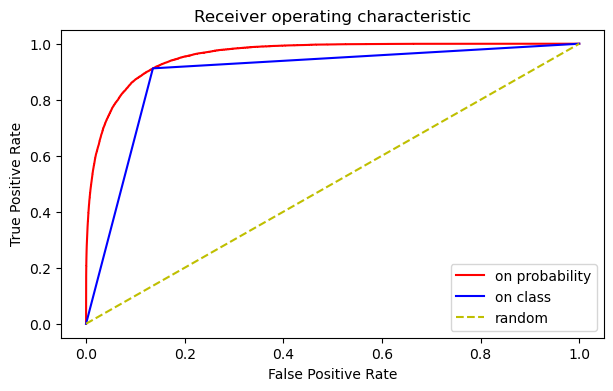

In [124]:
import matplotlib.pyplot as plt
print(f'Метрики лучшей модели на тестовой выборке:')
print_metrics(
    final_pipeline, x_test, y_test, best_threshold, show_roc_curve=True)

In [203]:
final_model = final_pipeline.named_steps['model']
final_preprocessor = final_pipeline.set_params(model=None)
sessions_preprocessed = final_preprocessor.fit_transform(df_session)

In [204]:
sessions_preprocessed.duplicated().sum()
sessions_preprocessed = sessions_preprocessed.drop_duplicates()
sessions_preprocessed.duplicated().sum()

0

In [206]:
sessions_preprocessed['target']=sessions_preprocessed['target'].astype('int')
sessions_preprocessed

,target,visit_date_weekday,visit_date_month,visit_date_day,visit_time_hour,device_screen_width,device_screen_height,geo_city_distance_from_moscow,x1_lada-vaz,x1_mercedes-benz,...,x6_500-1000 km,x6_< 100 km,x6_>= 3000 km,x6_moscow,x6_no distance,x7_Android Webview,x7_Chrome,x7_Safari,x7_Safari (in-app),x7_YaBrowser
0,0,-0.904827,1.246322,1.244617,-1.801552,-0.754548,-0.984540,1.942253,-0.219991,-0.254124,...,-0.560765,-0.273021,4.921227,-0.737741,-0.270494,-0.190734,0.965413,-0.575790,-0.219585,-0.316636
1,0,1.049143,-1.831314,1.351174,-1.383109,-0.518695,-0.424352,-0.932322,-0.219991,-0.254124,...,-0.560765,-0.273021,-0.203201,1.355488,-0.270494,-0.190734,0.965413,-0.575790,-0.219585,-0.316636
2,0,-1.594924,-1.831314,1.563029,-0.298090,-0.644381,-0.219227,0.575484,-0.219991,-0.254124,...,1.783277,-0.273021,-0.203201,-0.737741,-0.270494,-0.190734,-1.035826,1.736743,-0.219585,-0.316636
3,0,0.166218,1.246322,1.457307,-0.932523,0.533790,1.205230,0.575484,-0.219991,-0.254124,...,1.783277,-0.273021,-0.203201,-0.737741,-0.270494,-0.190734,-1.035826,-0.575790,-0.219585,3.158204
4,0,-1.594924,-1.402411,-0.537291,0.877642,-0.754548,-1.747727,0.575484,-0.219991,-0.254124,...,1.783277,-0.273021,-0.203201,-0.737741,-0.270494,-0.190734,0.965413,-0.575790,-0.219585,-0.316636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128595,0,1.049143,-0.660944,-1.524850,0.534627,1.789843,1.476982,-0.866823,-0.219991,-0.254124,...,-0.560765,3.662715,-0.203201,-0.737741,-0.270494,-0.190734,0.965413,-0.575790,-0.219585,-0.316636
1128596,4,-0.335940,-1.076594,0.922222,1.051017,-0.754548,-0.312859,0.575484,-0.219991,-0.254124,...,1.783277,-0.273021,-0.203201,-0.737741,-0.270494,5.242907,-1.035826,-0.575790,-0.219585,-0.316636
1128597,0,1.049143,1.246322,-1.524850,-0.777084,-0.580672,0.094966,1.164135,-0.219991,-0.254124,...,-0.560765,-0.273021,-0.203201,-0.737741,-0.270494,-0.190734,0.965413,-0.575790,-0.219585,-0.316636
1128598,0,1.049143,1.246322,-1.524850,-0.777084,-0.580672,0.094966,1.164135,-0.219991,-0.254124,...,-0.560765,-0.273021,-0.203201,-0.737741,-0.270494,-0.190734,0.965413,-0.575790,-0.219585,-0.316636


In [207]:
sessions_preprocessed.loc[sessions_preprocessed['target'] == 4, 'target'] = sessions_preprocessed['target'].apply(lambda x: 1).astype('int')


# Финальная модель 

In [209]:
X_new=sessions_preprocessed.drop(['target'], axis=1)
y_new=sessions_preprocessed['target']
x_train_new, x_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.3, random_state=40)

In [210]:
lightgbm_best = LGBMClassifier(random_state=128, learning_rate=0.2117116063, boosting_type='gbdt', 
        n_estimators=2870, reg_lambda=8.695904105, reg_alpha=3.43652345, num_leaves=115)
lightgbm_best.fit(x_train_new, y_train_new)
print_metrics(lightgbm_best, x_test_new, y_test_new)

Порог перевода вероятностей в классы: 0.040323906268912746
0.7392913465730192 - roc_auc на вероятностях

0.67709247 - roc_auc
0.67379435 - accuracy
0.10757744 - precision
0.68079547 - recall
0.18579592 - f1

prediction|    0     |    1     
true label|          |          
--------------------------------
         0|    160431|     77813
         1|      4398|      9380


# Анализ влияния feauture на результаты моделирования
В итоге всех преобразований получается 25 признака


In [212]:
# выведем features и отсортируем по убыванию, чтобы понять, какие фичи вносят больший результат
lightgbm_best.feature_importances_
f_imp_list = list(zip(X_new.columns, lightgbm_best.feature_importances_))
f_imp_list.sort(key = lambda x: x[1], reverse=True)
f_imp_list=pd.DataFrame({"features": X_new.columns, "feature_importances": lightgbm_best.feature_importances_})
f_imp_list['feature_importances'].describe()

count       25.000000
mean     13087.200000
std      23355.250352
min          0.000000
25%        171.000000
50%        424.000000
75%      20993.000000
max      66210.000000
Name: feature_importances, dtype: float64

In [213]:
# обрежем features, которые имеют вклад 0 в модель, осталось 112 features 
f_imp_list_cut = f_imp_list.loc[f_imp_list['feature_importances']>0, :]
f_imp_list_cut['feature_importances'].describe()

count       24.000000
mean     13632.500000
std      23694.444407
min          2.000000
25%        178.500000
50%        436.000000
75%      21040.000000
max      66210.000000
Name: feature_importances, dtype: float64

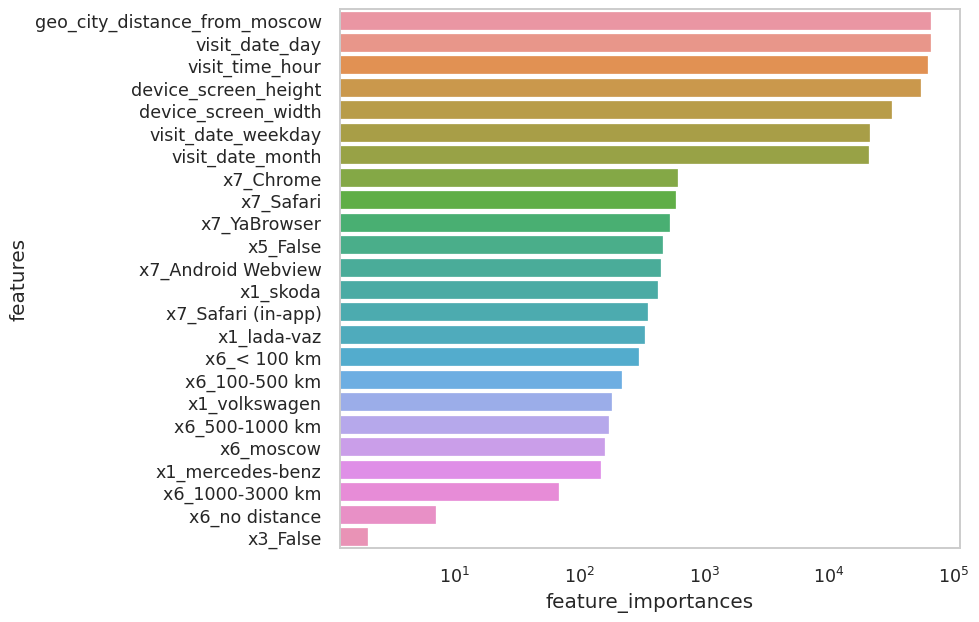

<Figure size 800x700 with 0 Axes>

In [214]:
## Выведем фичи, значения которых максимально вносят вклад в модель, логично, что это все revenue

from jupyterthemes import jtplot

jtplot.style(context='notebook', ticks=True, grid=False)
f_imp_list_cut = f_imp_list_cut.sort_values('feature_importances', ascending=False) 
sns.barplot(f_imp_list_cut['feature_importances'], f_imp_list_cut['features']).set(xscale="log")  
plt.figure()  
plt.show() 
sns.set (font_scale=0.04)

# Сохраним модель

In [216]:
import pickle
#cериализация модели 
filename = 'model.pickle'

with open(filename, 'wb') as file:
  pickle.dump(lightgbm_best, file) 


Выводы

Было проверено 10 моделей с гиперпараметрами по умолчанию. В тройке лучших оказались алгоритмы бустинга от sklearn, lightgbm и catboost.

В итоге в качестве лучшей модели был выбран LightGBM по следующим причинам:

Один из лучших показателей roc_auc.
Быстрое обучение.
Модель интерпретируема, то есть можно получить показатели важности признаков.
Может предсказывать вероятность класса.

Качество модели по метрике roc-auc составляет 0.73 (0.67 при предсказании классов). Переобучения нет и цель проекта выполнена - roc-auc > 0.65.

Для улучшения качества предсказания можно было бы:

Увеличить количество данных. Тестовая выборка пойдёт на дообучение модели, так что может модель будет лучше в конечном итоге.
Провести ребалансировку классов. Но если уменьшить выборку с отрицательной целевой переменной, то модель теряет в качестве, а если увеличивать выборку с положительным классом, то модели обучаются слишком долго.
Провести более тщательный поиск наилучших гиперпараметров - это займёт много времени, а прирост качества будет небольшим.
Провести дополнительную генерацию признаков. Но хорошие идеи придумывать сложно.
Попробовать более сложные модели, например, нейронные сети глубокого обучения.